# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [2]:
#%%pycodestyle

import sklearn.metrics as metrics


class MyKmeans:
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', min_eps=1e-7):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.min_eps = min_eps

    def randomize(self, choices):
        p = 0

        rand = np.random.uniform(0, sum(choices))

        for i in range(choices.shape[0]):
            if p + choices[i] >= rand:
                return i

            p += choices[i]

    def init_centroids(self, X):
        if self.init == 'random':
            for i in range(self.k):
                self.centroids[i] = X[np.random.randint(X.shape[0])]
        else:
            self.centroids[0] = X[np.random.randint(X.shape[0])]

            for i in range(1, self.k):
                Y = metrics.pairwise_distances(
                    self.centroids[:i], X, metric=self.metric)

                distances_min = np.min(Y, axis=0)

                self.centroids[i] = X[self.randomize(distances_min)]

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массивы с центроидами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        self.new_centroids = np.empty((self.k, X.shape[1]))

        self.init_centroids(X)

        eps = 1

        i = 0

        while (i < self.max_iter) and (eps > self.min_eps):
            Y = metrics.pairwise_distances(
                self.centroids, X, metric=self.metric)

            self.labels = np.argmin(Y, axis=0)

            for label in range(self.k):
                x_label = X[label == self.labels]

                self.new_centroids[label] = sum(x_label) / len(x_label)

            dist_centroids = metrics.pairwise_distances(
                self.centroids, self.new_centroids, metric=self.metric)

            self.centroids = self.new_centroids

            eps = max(dist_centroids.diagonal())

            i += 1

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """

        Y = metrics.pairwise_distances(self.centroids, X, metric=self.metric)

        return np.argmin(Y, axis=0)


class MiniBatchMyKMeans(MyKmeans):

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', min_eps=1e-7, batch_k=0.1):
        self.batch_k = batch_k

        MyKmeans.__init__(self, k, metric, max_iter,
                          random_state, init, min_eps)

    def fit(self, X, y=None):

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        batch_size = int(self.batch_k * X.shape[0])

        # Массив с метками кластеров для каждого объекта
        self.labels = np.empty(batch_size)

        # Массивы с центроидами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        self.new_centroids = np.empty((self.k, X.shape[1]))

        self.init_centroids(X)

        label_points = np.zeros(shape=(self.k))

        eps = 1

        i = 0

        while (i < self.max_iter) and (eps > self.min_eps):
            batch = X[np.random.randint(X.shape[0], size=batch_size)]

            Y = metrics.pairwise_distances(
                self.centroids, batch, metric=self.metric)

            self.labels = np.argmin(Y, axis=0)

            for j in range(batch_size):
                label = self.labels[j]

                label_points[label] += 1

                k = 1.0 / label_points[label]

                self.new_centroids[label] = k * batch[j] + \
                    (1 - k) * self.centroids[label]

            dist_centroids = metrics.pairwise_distances(
                self.centroids, self.new_centroids, metric=self.metric)

            self.centroids = self.new_centroids

            eps = max(dist_centroids.diagonal())

            i += 1

        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1,
                  center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

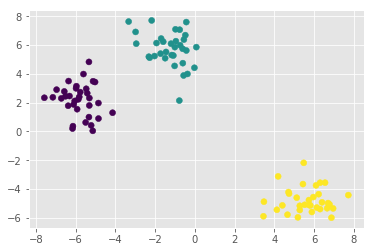

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

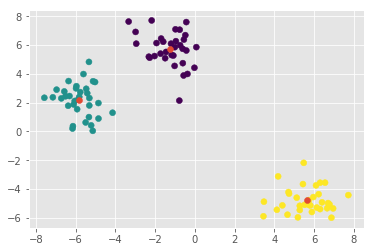

In [6]:
## Работоспособность MyKmeans
kmeans = MyKmeans(k=3, random_state=2)
kmeans.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=kmeans.predict(X))
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1])

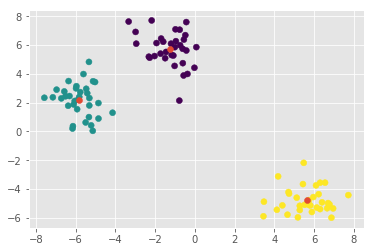

In [7]:
## Работоспособность MyKmeans++
kmeans_pp = MyKmeans(k=3, random_state=2, init='k-means')
kmeans_pp.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=kmeans_pp.predict(X))
plt.scatter(kmeans_pp.centroids[:, 0], kmeans_pp.centroids[:, 1])

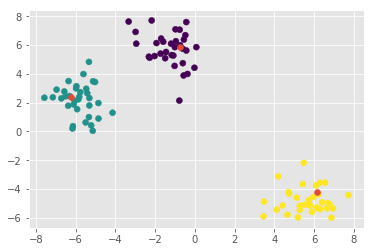

In [8]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
kmeans_minibatch = MiniBatchMyKMeans(k=3, random_state=2)
kmeans_minibatch.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=kmeans_minibatch.predict(X))
plt.scatter(kmeans_minibatch.centroids[:, 0], kmeans_minibatch.centroids[:, 1])

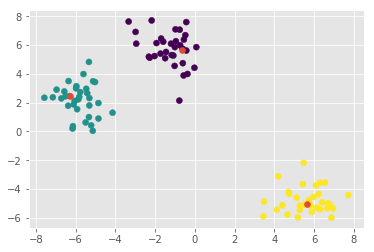

In [9]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
kmeans_pp_minibatch = MiniBatchMyKMeans(k=3, random_state=2, init='k-means')
kmeans_pp_minibatch.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=kmeans_pp_minibatch.predict(X))
plt.scatter(kmeans_pp_minibatch.centroids[:, 0],
            kmeans_pp_minibatch.centroids[:, 1])

In [10]:
import time

n_points = [500, 1000, 5000, 10000, 25000, 50000]

t = np.empty(len(n_points))

n_samples:   500, time: 0.048s
n_samples:  1000, time: 0.048s
n_samples:  5000, time: 0.076s
n_samples: 10000, time: 0.138s
n_samples: 25000, time: 0.453s
n_samples: 50000, time: 0.833s


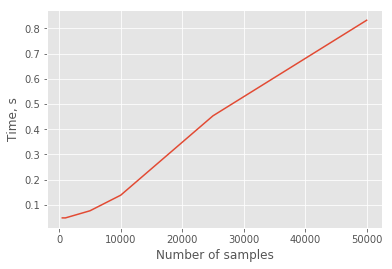

In [11]:
## Время выполнения алгоритма Kmeans из sklearn
from sklearn.cluster import KMeans

for i, n in enumerate(n_points):
    kmeans = KMeans(n_clusters=3, random_state=2)

    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1,
                      center_box=(-10.0, 10.0), shuffle=False,
                      random_state=1234)

    t0 = time.time()
    kmeans.fit(X)
    t[i] = time.time() - t0

for i, j in enumerate(t):
    print("n_samples:", "{:>6}".format(
        n_points[i]), ', time: ', "{:.3f}".format(round(j, 3)), 's', sep='')

plt.plot(n_points, t)

plt.xlabel('Number of samples')
plt.ylabel('Time, s')

plt.show()

n_samples:   500, time: 0.009s
n_samples:  1000, time: 0.014s
n_samples:  5000, time: 0.049s
n_samples: 10000, time: 0.103s
n_samples: 25000, time: 0.216s
n_samples: 50000, time: 0.406s


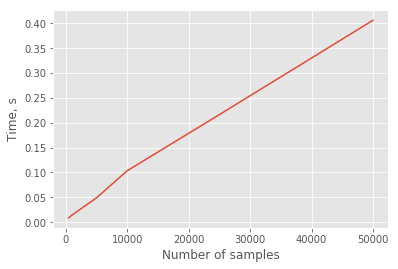

In [12]:
## Время выполнения алгоритма MyKmeans
for i, n in enumerate(n_points):
    my_kmeans = MyKmeans(k=3, random_state=2)

    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1,
                      center_box=(-10.0, 10.0), shuffle=False,
                      random_state=1234)

    t0 = time.time()
    my_kmeans.fit(X)
    t[i] = time.time() - t0

for i, j in enumerate(t):
    print("n_samples:", "{:>6}".format(
        n_points[i]), ', time: ', "{:.3f}".format(round(j, 3)), 's', sep='')

plt.plot(n_points, t)

plt.xlabel('Number of samples')
plt.ylabel('Time, s')

plt.show()

n_samples:   500, time: 0.011s
n_samples:  1000, time: 0.014s
n_samples:  5000, time: 0.102s
n_samples: 10000, time: 0.159s
n_samples: 25000, time: 0.322s
n_samples: 50000, time: 0.601s


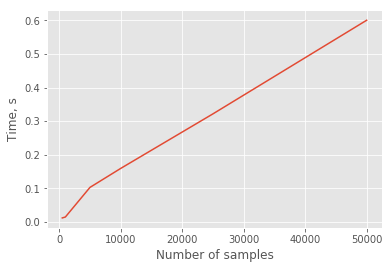

In [13]:
## Время выполнения алгоритма MyKmeans++
for i, n in enumerate(n_points):
    my_kmeans_pp = MyKmeans(k=3, random_state=2, init='k-means')

    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1,
                      center_box=(-10.0, 10.0), shuffle=False,
                      random_state=1234)

    t0 = time.time()
    my_kmeans_pp.fit(X)
    t[i] = time.time() - t0

for i, j in enumerate(t):
    print("n_samples:", "{:>6}".format(
        n_points[i]), ', time: ', "{:.3f}".format(round(j, 3)), 's', sep='')

plt.plot(n_points, t)

plt.xlabel('Number of samples')
plt.ylabel('Time, s')

plt.show()

n_samples:   500, time: 0.011s
n_samples:  1000, time: 0.015s
n_samples:  5000, time: 0.105s
n_samples: 10000, time: 0.160s
n_samples: 25000, time: 0.336s
n_samples: 50000, time: 0.616s


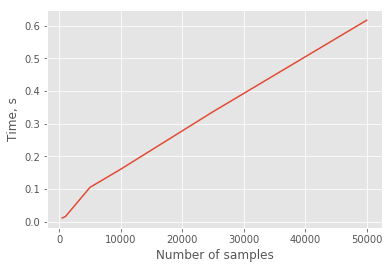

In [14]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
for i, n in enumerate(n_points):
    my_kmeans_minibatch = MyKmeans(k=3, random_state=2, init='k-means')

    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1,
                      center_box=(-10.0, 10.0), shuffle=False,
                      random_state=1234)

    t0 = time.time()
    my_kmeans_minibatch.fit(X)
    t[i] = time.time() - t0

for i, j in enumerate(t):
    print("n_samples:", "{:>6}".format(
        n_points[i]), ', time: ', "{:.3f}".format(round(j, 3)), 's', sep='')

plt.plot(n_points, t)

plt.xlabel('Number of samples')
plt.ylabel('Time, s')

plt.show()

n_samples:   500, time: 0.011s
n_samples:  1000, time: 0.017s
n_samples:  5000, time: 0.065s
n_samples: 10000, time: 0.104s
n_samples: 25000, time: 0.245s
n_samples: 50000, time: 0.495s


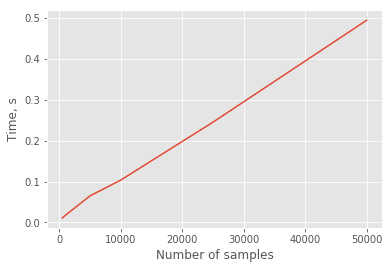

In [24]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
for i, n in enumerate(n_points):
    my_kmeans_pp_minibatch = MyKmeans(k=3, random_state=2, init='k-means')

    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1,
                      center_box=(-10.0, 10.0), shuffle=False,
                      random_state=1234)
    t0 = time.time()
    my_kmeans_pp_minibatch.fit(X)
    t[i] = time.time() - t0

for i, j in enumerate(t):
    print("n_samples:", "{:>6}".format(
        n_points[i]), ', time: ', "{:.3f}".format(round(j, 3)), 's', sep='')

plt.plot(n_points, t)

plt.xlabel('Number of samples')
plt.ylabel('Time, s')

plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [16]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [17]:
df_sns_cutted = df_sns.iloc[:, 4:]

df_sns_norm = (df_sns_cutted - df_sns_cutted.mean(axis=0)) / \
    df_sns_cutted.std(axis=0)

X = df_sns_norm.as_matrix()

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

Кластер: 1


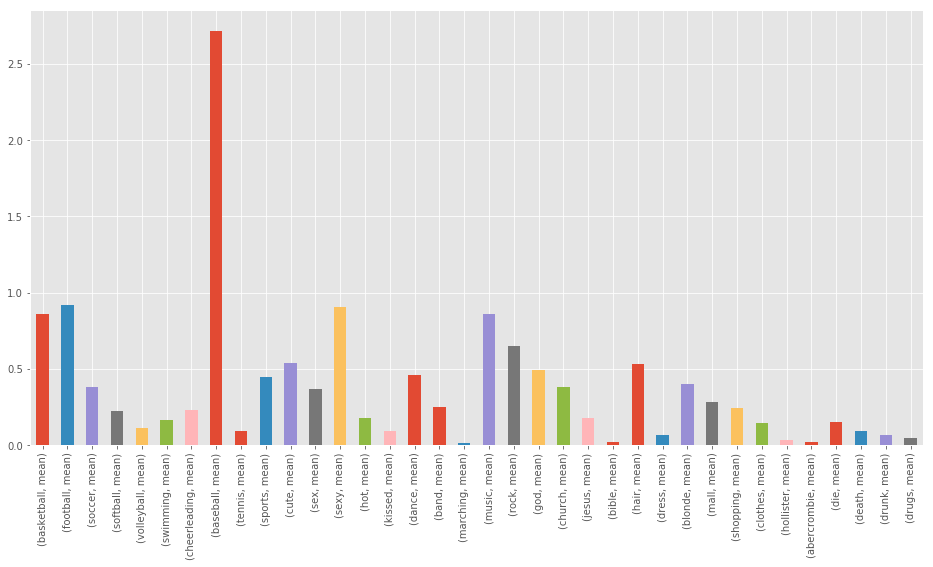

Кластер: 2


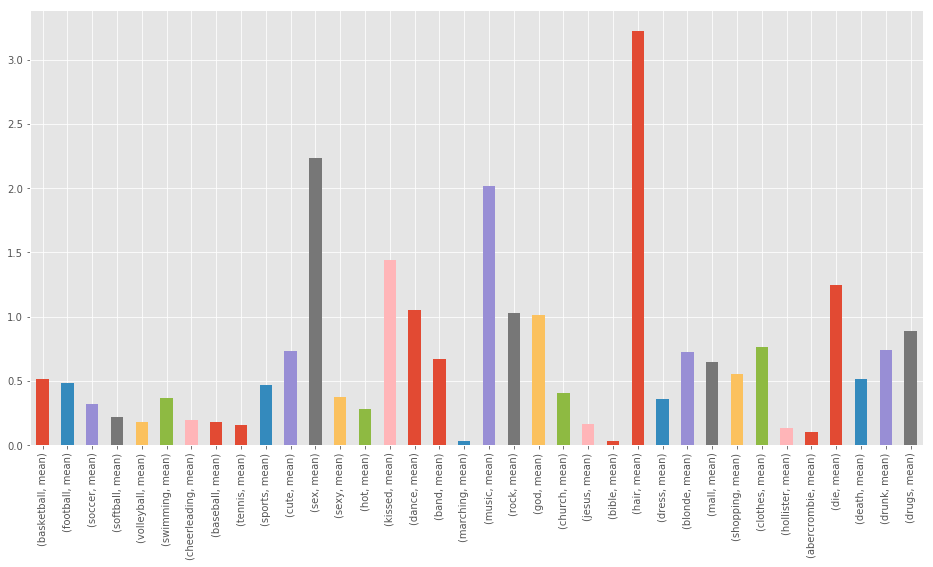

Кластер: 3


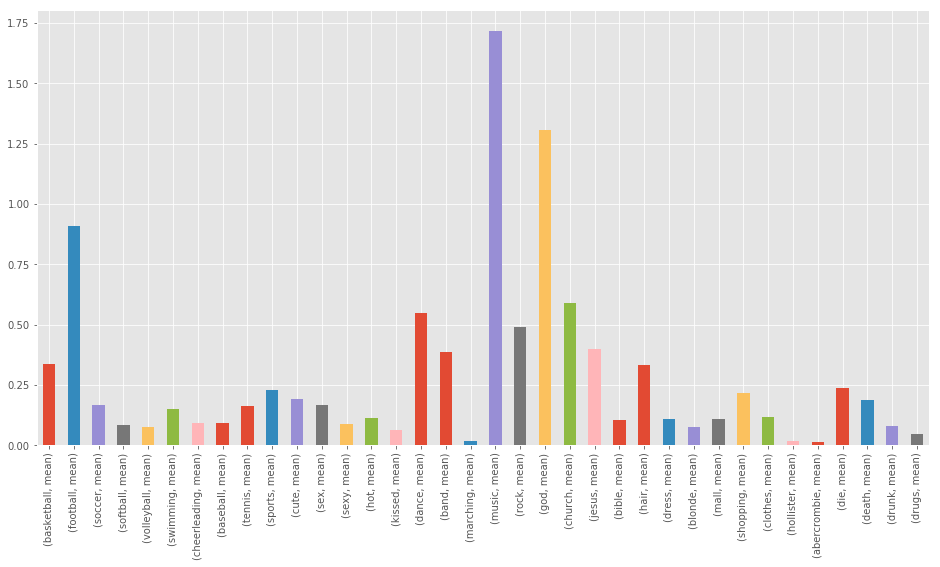

Кластер: 4


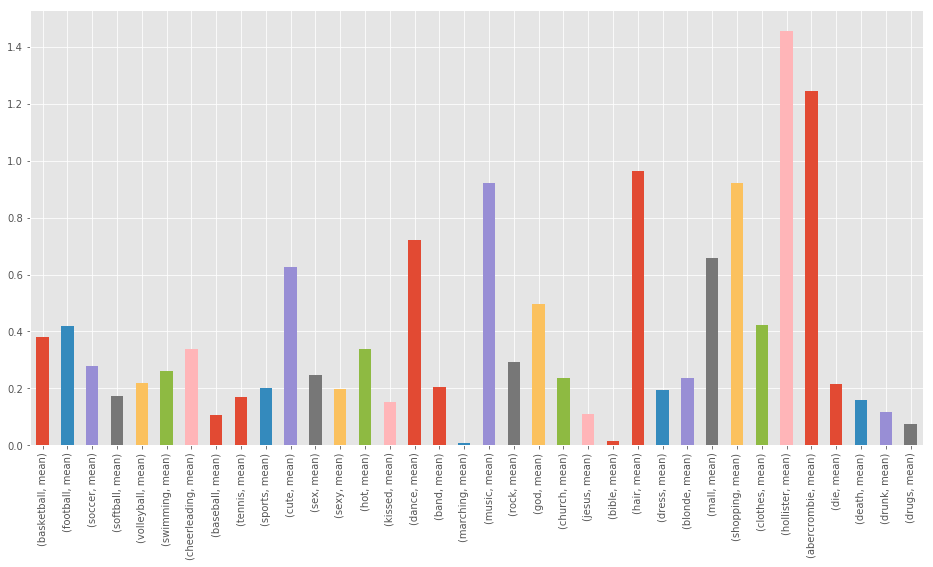

Кластер: 5


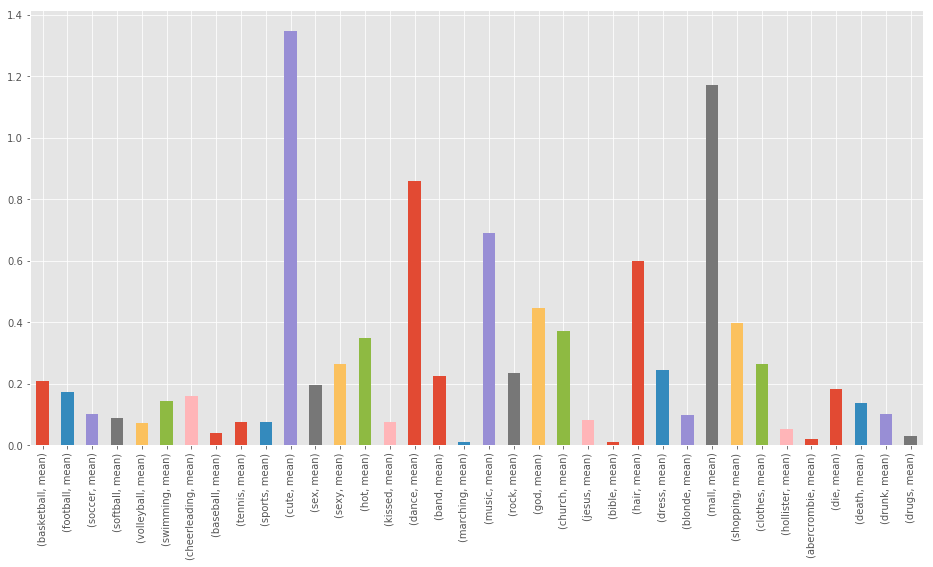

Кластер: 6


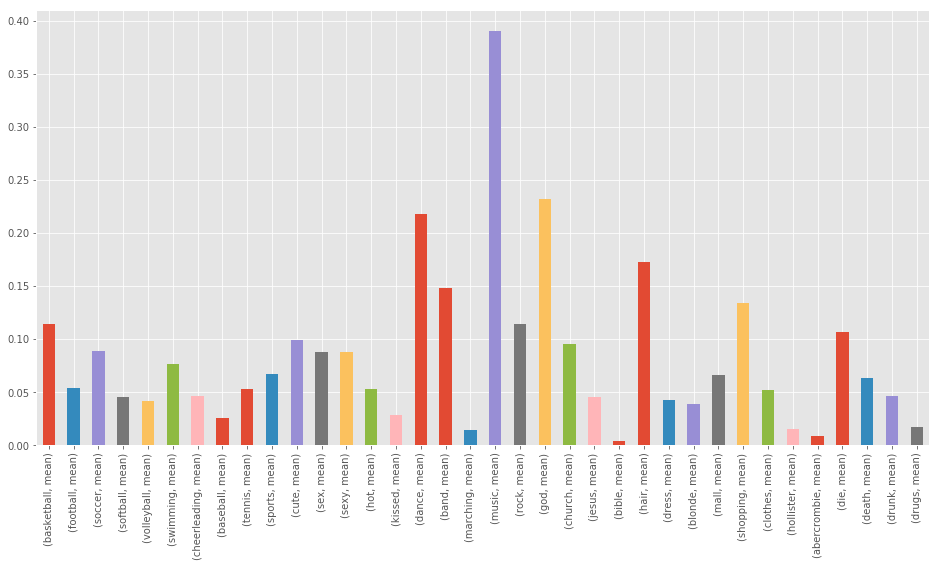

Кластер: 7


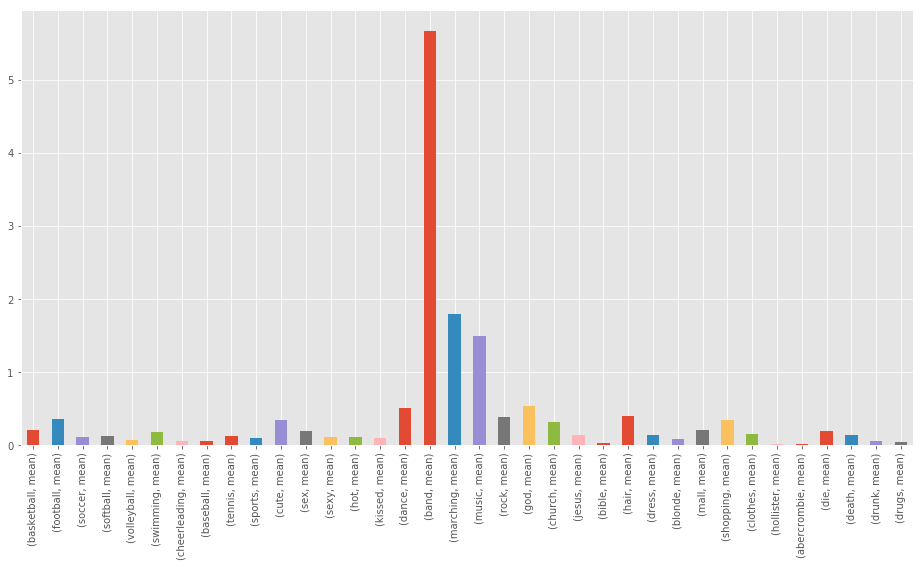

Кластер: 8


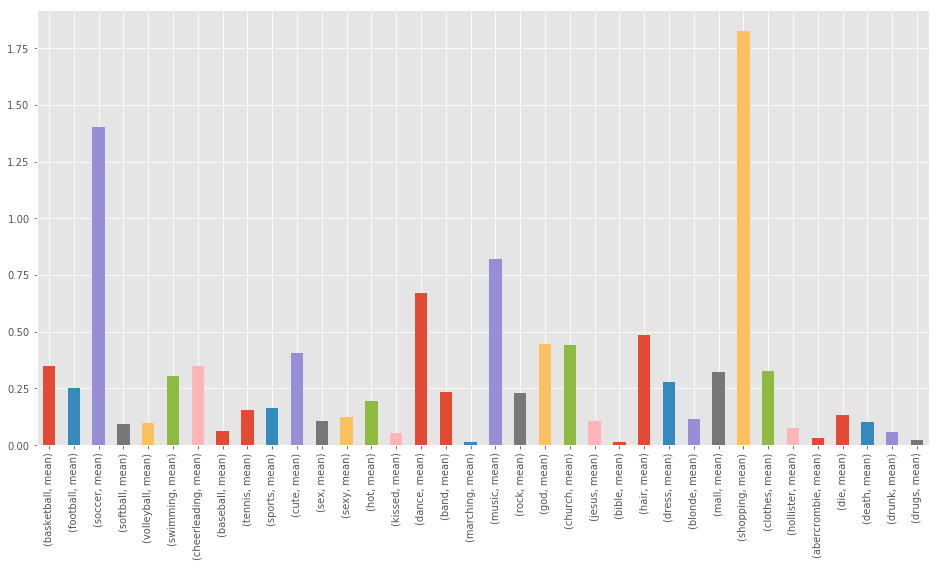

Кластер: 9


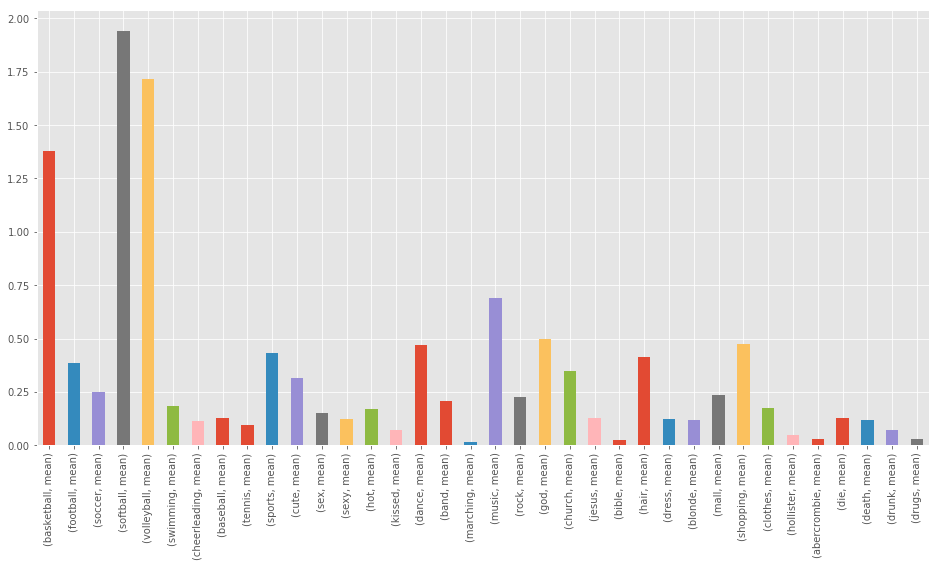

In [18]:
## MyKMeans
my_kmeans = MyKmeans(k=9, random_state=4)
my_kmeans.fit(X)

df_sns.loc[:, 'Kmeans'] = my_kmeans.fit(X).predict(X)

count_age = df_sns.groupby('Kmeans')['age'].aggregate(['count'])
mean = df_sns.groupby('Kmeans').aggregate(['mean'])

tb = pd.concat([count_age, mean], axis=1)

for i in range(0, 9):
    print("Кластер: {}".format(i+1))

    plt.figure(figsize=(16, 8))

    tb.iloc[i, 4:40].plot.bar()

    plt.show()

In [19]:
## MyKMeans++
my_kmeans_pp = MyKmeans(k=9, random_state=4, init='k-means')

df_sns.loc[:, 'Kmeans'] = my_kmeans_pp.fit(X).predict(X)

count_age = df_sns.groupby('Kmeans')['age'].aggregate(['count'])
mean = df_sns.groupby('Kmeans').aggregate(['mean'])

pd.concat([count_age, mean], axis=1)

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(blonde, mean)","(mall, mean)","(shopping, mean)","(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)"
Kmeans,,,,,,,,,,,,,,,,,,,,,
0,451,2007.711799,17.289049,33.831721,0.901354,0.982592,0.332689,0.326886,0.241779,0.187621,...,0.433269,0.266925,0.259188,0.127660,0.044487,0.032882,0.152805,0.085106,0.061896,0.058027
1,1702,2007.801500,17.466307,40.231000,0.869000,0.316500,0.166000,0.366000,0.328000,0.247000,...,0.170000,1.834000,0.991000,0.159000,0.358500,0.280500,0.243000,0.112000,0.142500,0.127000
2,498,2007.426598,18.086016,32.616580,0.259067,0.262522,0.086356,0.150259,0.151986,0.145078,...,0.751295,0.374784,0.355786,0.255613,0.094991,0.091537,1.319516,2.181347,0.338515,0.366149
3,482,2007.760070,17.637189,36.066550,0.532399,0.427320,5.383538,0.192644,0.197898,0.182137,...,0.169877,0.260946,0.570928,0.133100,0.108581,0.066550,0.217163,0.113835,0.092820,0.070053
4,3331,2007.521852,17.903035,32.859001,0.454214,1.112903,0.167014,0.292664,0.290323,0.189906,...,0.066857,0.100676,0.288762,0.038762,0.030437,0.023673,0.180801,0.083247,0.076483,0.030437
5,1789,2007.585868,17.842970,33.096865,0.178755,0.124942,0.123070,0.134768,0.116986,0.103884,...,0.104352,0.170800,0.307440,0.080955,0.058025,0.037904,0.160505,0.071596,0.123538,0.049134
6,13828,2007.421130,18.196053,26.928802,0.119760,0.025575,0.092480,0.085425,0.074490,0.085190,...,0.042095,0.092186,0.208243,0.019754,0.025869,0.017109,0.111882,0.054559,0.044565,0.019989
7,1616,2007.666839,17.513830,33.656524,0.298092,0.257865,0.165034,0.252708,0.214544,0.289840,...,0.150593,0.337803,0.844765,1.421351,0.185147,0.124291,0.243940,0.115523,0.130480,0.114492
8,1217,2007.451567,17.908659,33.918803,0.440883,0.393162,0.183048,0.272080,0.187322,0.206553,...,0.273504,0.408832,0.708689,0.308405,0.141738,0.115385,0.467236,0.146724,0.358974,0.351140


In [20]:
## MyKMeans с MiniBatchMyKMeans
my_kmeans_minibatch = MiniBatchMyKMeans(k=9, random_state=4)

df_sns.loc[:, 'Kmeans'] = my_kmeans_minibatch.fit(X).predict(X)

count_age = df_sns.groupby('Kmeans')['age'].aggregate(['count'])
mean = df_sns.groupby('Kmeans').aggregate(['mean'])

pd.concat([count_age, mean], axis=1)

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(blonde, mean)","(mall, mean)","(shopping, mean)","(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)"
Kmeans,,,,,,,,,,,,,,,,,,,,,
0,667,2007.748387,17.501471,34.561290,0.716129,0.752258,0.356129,0.203871,0.100645,0.126452,...,0.331613,0.238710,0.261935,0.178065,0.056774,0.033548,0.169032,0.121290,0.121290,0.051613
1,1170,2007.630848,17.944247,30.695906,0.393275,0.407895,0.281433,0.168129,0.157895,0.802632,...,0.685673,0.711257,0.515351,0.617690,0.138158,0.071637,1.264620,0.417398,0.496345,0.588450
2,3457,2007.434141,17.995301,31.746313,0.249938,0.936766,0.195451,0.065234,0.055236,0.117221,...,0.059985,0.089228,0.203449,0.110972,0.030992,0.014246,0.187203,0.148213,0.093227,0.057236
3,506,2007.794915,17.921723,42.340678,0.413559,0.403390,0.311864,0.152542,0.215254,0.235593,...,0.301695,0.576271,0.862712,0.472881,1.264407,1.481356,0.315254,0.203390,0.176271,0.232203
4,3379,2007.592509,17.670299,34.152086,0.157114,0.129462,0.114128,0.074409,0.054801,0.114379,...,0.073906,1.048768,0.333585,0.203369,0.067622,0.029663,0.156863,0.128457,0.102061,0.037707
5,11900,2007.408381,18.195745,26.030754,0.088205,0.044204,0.098885,0.034133,0.027847,0.059682,...,0.039878,0.025482,0.121190,0.056911,0.021561,0.011085,0.100034,0.067996,0.045691,0.018925
6,361,2007.382353,18.243277,32.107843,0.191176,0.352941,0.132353,0.142157,0.080882,0.178922,...,0.080882,0.237745,0.367647,0.156863,0.014706,0.014706,0.183824,0.144608,0.071078,0.044118
7,1801,2007.621876,17.751096,36.301744,0.502122,0.238095,1.248468,0.074965,0.070250,0.235266,...,0.111268,0.384724,1.966054,0.332862,0.127298,0.054220,0.136256,0.115512,0.065064,0.034889
8,1673,2007.752037,17.670057,37.439409,1.328921,0.317719,0.222505,1.567719,1.446029,0.161914,...,0.102851,0.205703,0.467923,0.167006,0.065682,0.039206,0.131874,0.116090,0.071283,0.040733


In [21]:
## MyKMeans++ с MiniBatchMyKMeans
my_kmeans_minibatch_pp = MiniBatchMyKMeans(k=9, random_state=4, init='k-means')

df_sns.loc[:, 'Kmeans'] = my_kmeans_minibatch_pp.fit(X).predict(X)

count_age = df_sns.groupby('Kmeans')['age'].aggregate(['count'])
mean = df_sns.groupby('Kmeans').aggregate(['mean'])

pd.concat([count_age, mean], axis=1)

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(blonde, mean)","(mall, mean)","(shopping, mean)","(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)"
Kmeans,,,,,,,,,,,,,,,,,,,,,
0,511,2007.725888,17.419162,34.194585,0.822335,0.888325,0.301184,0.429780,0.225042,0.221658,...,0.368866,0.245347,0.306261,0.138748,0.084602,0.064298,0.199662,0.096447,0.113367,0.077834
1,2088,2007.743977,17.413535,37.866068,0.995917,0.468763,0.187832,0.335239,0.307472,0.242956,...,0.173949,1.708044,0.751735,0.164149,0.216007,0.155165,0.267864,0.104532,0.147407,0.156390
2,368,2007.396313,17.625334,32.419355,0.244240,0.264977,0.117512,0.175115,0.124424,0.124424,...,0.896313,0.350230,0.382488,0.232719,0.092166,0.092166,0.907834,2.587558,0.271889,0.221198
3,347,2007.797101,17.613937,35.152174,0.599034,0.541063,5.980676,0.200483,0.224638,0.195652,...,0.205314,0.277778,0.586957,0.164251,0.108696,0.079710,0.234300,0.123188,0.123188,0.120773
4,3697,2007.504525,18.104453,30.204920,0.239963,0.934324,0.162683,0.177071,0.157113,0.132745,...,0.052448,0.068926,0.251799,0.035043,0.032722,0.025528,0.158970,0.072407,0.066373,0.035275
5,1880,2007.589996,17.854245,33.918267,0.172845,0.145601,0.138901,0.143368,0.144261,0.114337,...,0.107637,0.188924,0.363109,0.107637,0.080840,0.059402,0.177758,0.076820,0.125949,0.066101
6,12900,2007.418859,18.198046,27.387700,0.115385,0.016493,0.113811,0.103047,0.094108,0.098137,...,0.044882,0.078245,0.235553,0.008624,0.034307,0.024361,0.127156,0.060305,0.051933,0.022347
7,1658,2007.632397,17.534024,31.984453,0.247743,0.206620,0.158475,0.200100,0.191575,0.228185,...,0.126881,0.296389,0.728686,1.435306,0.173019,0.109328,0.237713,0.115848,0.130893,0.104814
8,1465,2007.497031,17.828055,34.954869,0.589667,0.315321,0.226841,0.286223,0.228029,0.195368,...,0.247625,0.339667,0.633017,0.244062,0.130641,0.116390,0.404394,0.158551,0.230404,0.222090


### Интерпретация кластеров:
<p><br/>
<b>Кластер 0</b>: любят спорт - бейсбол, футбол, баскетбол (baseball, football, basketball)
<p>
<b>Кластер 1</b>: следят за внешностью, любят музыку; общительны (hair, music, sex)
<p>
<b>Кластер 2</b>: любят музыку, футбол; религиозны (music, football, god, church)
<p>
<b>Кластер 3</b>: следят за внешностью (abercrombie)
<p>
<b>Кластер 4</b>: обыватели; увлекаются музыкой, танцами (cute, mall, music, dance)
<p>
<b>Кластер 5</b>: увлекаются музыкой, танцами; религиозны (music, dance, god)
<p>
<b>Кластер 6</b>: общительные (band)
<p>
<b>Кластер 7</b>: увлекаются футболом, шопингом (soccer, shopping)    
<p>
<b>Кластер 8</b>: любят спорт - софтбол, волейбол, баскетбол (softball, volleyball, basketball)

### Вывод

Kmeans: случайно выбранные центры кластеров могут оказаться слишком близко друг к другу, что может привести к неверной кластеризации

MiniBatch: выигрыш во времени, но при этом падает точность

KMeans++: время кластеризации значительно растет по мере увеличения числа точек; безопасный выбор центров кластеров (в отличие от Kmeans)